# **Fine Tuning BERT for MultiLabel Cloud Sentences Classification**

The objective of this notebook is to fine tune BERT to be able to label a sentence into the following categories:
 - `compute`
 - `data handling`
 - `network`
 - `security & compliance`
 - `management & monitoring`
 - `cloud service essentials`

It is to be noted that the outputs to the BERT model are different from DistilBert Model implemented by the Hugging Face team. There are no token_type_ids generated from the tokenizer in case of Distilbert and also the final outputs from the network differ.



Useful Resources:

1.   https://github.com/shaheerzubery/Multi-label-classification/blob/main/Multilabel_Classificatinn_using_bert.ipynb
2.   https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb
3. https://www.kaggle.com/code/satyamkryadav/bert-model-96-77/notebook
4. https://github.com/wrobbins0409/cse30124-project/blob/main/sentiment_analysis_train.py
5. https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=it
6. https://github.com/laxmimerit/NLP-Tutorials-with-HuggingFace/blob/main/5%20Fine%20Tuning%20DistilBERT%20for%20Multi-Label%20Classification%20%7C%20NLP%20with%20HuggingFace%20Tutorial.ipynb
7. https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/code?competitionId=8076&sortBy=voteCount&searchQuery=bert
8. https://www.kaggle.com/code/shravankumar147/bert-toxic-classifier-shravan

---

# **Importing Python Libraries and preparing the environment**

In this section, the libraries are imported.
The "device" is derived to take advantage of the GPU and thus speed up performance. Drive access is also required for access to models and files.

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Verify if CUDA (GPU support) is available in PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU disponibile: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
device

GPU disponibile: Tesla T4


device(type='cuda')

# **Data Preprocessing and Cleaning for Multi-label Classification**

Here is performed essential preprocessing on dataset to ensure that it is well-structured and clean before we proceed to model training. This preprocessing is crucial for effective model performance, especially in a multi-label classification context. The steps are as follows:

* **Convert Binary Columns**: converting the columns into integers. These columns represent target labels for the multi-label classification task. Converting them to integer type ensures that our model processes these labels correctly.

* **Replace Specific Terms in Descriptions**: is modified the 'description' column by replacing the term "bidder" with "provider." This normalization step is performed to maintain consistency in the terminology used throughout the dataset. It's important for natural language processing tasks to have a consistent use of language to improve the model's ability to understand and predict correctly.

* **Trimming Whitespace and Punctuation**: Next, we trim any leading and trailing whitespace from the 'description' column. This step ensures that our text data is clean and uniform, free from any formatting inconsistencies that might affect the model's performance. Additionally, we remove trailing periods from the descriptions. Such formatting adjustments help in standardizing the text data.

* **Removing Duplicates**: Finally, we remove duplicate entries based on the 'description' column (case insensitive). Duplicates can skew the training process and lead to overfitting, as the model might see the same example multiple times. For each duplicate, the first occurrence is retained.

In [ ]:
# Download the CSV dataset file from Google Drive (the file must have "whoever has the link" set)

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1v7oHXyu7GKxhaMWxO_S0GNxvUOAB2rA4' -O "final_dataset.csv"

--2024-03-02 13:53:59--  https://drive.google.com/uc?export=download&id=1v7oHXyu7GKxhaMWxO_S0GNxvUOAB2rA4
Resolving drive.google.com (drive.google.com)... 74.125.197.101, 74.125.197.102, 74.125.197.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1v7oHXyu7GKxhaMWxO_S0GNxvUOAB2rA4&export=download [following]
--2024-03-02 13:53:59--  https://drive.usercontent.google.com/download?id=1v7oHXyu7GKxhaMWxO_S0GNxvUOAB2rA4&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.20.132, 2607:f8b0:400e:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.20.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 604167 (590K) [application/octet-stream]
Saving to: ‘final_dataset.csv’

final_dataset.csv   100%[===================>] 590.01K  --.-KB/s

In [ ]:
# Store the dataset in a Dataframe
train_df = pd.read_csv("final_dataset.csv")

In [ ]:
# Check for any missing values in the dataset
missing_values = train_df.isnull().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
source                      0
description                 0
goal                        0
compute                     0
data handling               0
network                     0
security & compliance       0
management & monitoring     0
cloud service essentials    0
dtype: int64


In [ ]:
train_df.describe()

,goal,compute,data handling,network,security & compliance,management & monitoring,cloud service essentials
count,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000
mean,0.689016,0.124835,0.084252,0.102779,0.172034,0.262461,0.159682
std,0.462998,0.330604,0.277827,0.303737,0.377493,0.440069,0.366392
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
target_list = ['compute', 'data handling', 'network', 'security & compliance', 'management & monitoring', 'cloud service essentials']

# Convert binary columns from float to int
train_df[target_list] = train_df[target_list].astype(int)

# Normalization step to maintain consistency of the terminology
train_df['description'] = train_df['description'].apply(lambda x: x.replace("bidder", "provider").replace("Bidder", "Provider").replace("BIDDER", "Provider"))


train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   source                    2267 non-null   object
 1   description               2267 non-null   object
 2   goal                      2267 non-null   int64 
 3   compute                   2267 non-null   int64 
 4   data handling             2267 non-null   int64 
 5   network                   2267 non-null   int64 
 6   security & compliance     2267 non-null   int64 
 7   management & monitoring   2267 non-null   int64 
 8   cloud service essentials  2267 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 159.5+ KB


In [ ]:
train_df["description"] = train_df["description"].str.strip()
train_df["description"] = train_df["description"].str.rstrip('.')

In [ ]:
# Convert 'description' to lowercase for a case-insensitive duplicate check and store in a temporary column
train_df['temp_description_lower'] = train_df['description'].str.lower()

# Check for duplicates (put on variable to print)
duplicates_case_insensitive = train_df['temp_description_lower'].duplicated().sum()

# Drop duplicates based on the temporary lowercase column, keeping the first occurrence
train_df = train_df.drop_duplicates(subset=["temp_description_lower"], keep='first')

# Drop the temporary column
train_df = train_df.drop(columns=['temp_description_lower']).reset_index(drop=True)

print(f"Number of case-insensitive duplicates: {duplicates_case_insensitive}")


Number of case-insensitive duplicates: 103


In [ ]:
train_df = train_df.drop(columns=['source', 'goal']).reset_index(drop=True)

In [ ]:
print(len(train_df))

2164


In [ ]:
pd.set_option('display.max_rows', 10)

train_df

,description,compute,data handling,network,security & compliance,management & monitoring,cloud service essentials
0,The Provider will be responsible for provision...,1,1,1,0,0,0
1,The proposed landscape for the deployment of N...,0,0,0,0,0,0
2,The above environments are to be deployed on t...,0,0,1,0,0,0
3,The environment of Virtual Private Cloud/Gover...,0,0,0,1,0,0
4,Each of the environments mentioned above shoul...,0,0,1,0,0,0
...,...,...,...,...,...,...,...
2159,Any additional costing as per vendor specifica...,0,0,0,0,0,0
2160,The hosted virtual servers should only be bill...,0,0,0,0,1,0
2161,Any virtual servers that are switched off will...,0,0,0,0,1,0
2162,Costing must be on a resource use basis,0,0,0,0,0,0


### Download dataframes

In [ ]:
train_df.to_csv('./dataset_cleaned.csv', index=False)

# **Preparing the Dataset and Dataloader**

Here, the hyperparameters that will be used later during the training/end-tuning phase are defined. This is followed by the creation of the CustomDataset class, which defines how the text is preprocessed before being sent to the neural network. The Dataloader that will feed batch data to the neural network for proper training and processing will also be defined. Dataset and Dataloader are constructs in the PyTorch library to define and control the pre-processing of data and its passage to the neural network.


* The class **CustomDataset** is defined to accept as input the `tokenizer`, `dataframe` and `max_length` and generate tokenized output and tags that are used by the BERT model for training. We use BERT's tokenizer to tokenize the data in the `description` column of the dataframe. The tokenizer uses the `encode_plus` method to perform the tokenization and generate the necessary outputs, namely: `input_ids`, `attention_mask`, `token_type_ids`; `targest` is the list of categories labeled as 0 or 1 in the dataframe. The CustomDataset class is used to create two datasets, for training and for validation. The training dataset is used to fine-tune the model: 85% of the original data. The validation dataset is used to evaluate performance.

* **Dataloader** is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled. This control is achieved using the parameters such as `batch_size` and `max_len`. Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [ ]:
# # Sections of config

# Defining hyperparameters that will be used later on in the training
MAX_LEN = 300
TRAIN_BATCH_SIZE = VALID_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-05

#  load a tokenizer that is based on the model we will be fine tuning, in this case it will be a BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#tokenizer.save_pretrained("./gdrive/MyDrive/TESI/COLAB/MODELS/BERT-UNCASED/tokenizer/")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Tokenization example

In the process of encoding and decoding in the context of Natural Language Processing (NLP), "encoding" refers to the conversion of human readable text into a form that can be processed by an artificial intelligence model. This usually involves turning words into numbers, known as tokens. For example, the text "I look for 4 virtual machines to host our application" is converted into a series of numeric tokens, each representing a specific word or symbol.

On the other hand, "decoding" is the reverse process, where the numeric tokens are converted back into human readable text. This is important for interpreting the results produced by NLP models. The decoding process would return the numeric tokens to the original sentence, including special tokens such as [CLS], [SEP], and [PAD] that are used for specific purposes in the model (such as signaling the beginning, end of text, and padding).

In [ ]:
sentence = "Scalability is key as well"


tokens = tokenizer.tokenize(sentence)

encoded_input = tokenizer.encode_plus(
    sentence,
    add_special_tokens=True,
)


print("Tokens:", tokens)
print("Token IDs:", encoded_input['input_ids'])

Tokens: ['scala', '##bility', 'is', 'key', 'as', 'well']
Token IDs: [101, 26743, 8553, 2003, 3145, 2004, 2092, 102]


In [ ]:
token = tokenizer.convert_ids_to_tokens(2092)
print(token)

well


In [ ]:
# Example string
example_text = "Scalability is key as well; we expect our customer base to grow"

tokens = tokenizer.tokenize(example_text)
print("TOKENS:", [t for t in tokens])

print("\n")
print("ENCODING PHASE:")

# Tokenizing the example string
encoded_input = tokenizer.encode_plus(
    example_text,
    None,
    add_special_tokens=True,
    max_length=300,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print(encoded_input)

print("\nDECODING PHASE:")
decoded_text = tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=False)
print(decoded_text)

TOKENS: ['scala', '##bility', 'is', 'key', 'as', 'well', ';', 'we', 'expect', 'our', 'customer', 'base', 'to', 'grow']


ENCODING PHASE:
{'input_ids': tensor([[  101, 26743,  8553,  2003,  3145,  2004,  2092,  1025,  2057,  5987,
          2256,  8013,  2918,  2000,  4982,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,  

In [ ]:
max_len = 0
max_str = ""

for txt in train_df["description"]:
    tokens = tokenizer.encode(txt, max_length=512)
    token_len = len(tokens)
    if token_len > max_len:
        max_len = token_len
        max_str = txt

print(f"Massima lunghezza in token: {max_len}")
print("Stringa con massima lunghezza in token:", max_str)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Massima lunghezza in token: 262
Stringa con massima lunghezza in token: The Supplier shall provide effective support to Customers including, but not limited to: a) Providing a responsive account executive (with applicable back-up) assigned to the Customer to support their needs by providing day-to-day and ongoing administrative support, and operational support; b) Managing issue resolution in a timely manner; c) Complying with agreed upon escalation processes to resolve outstanding issues; d) Responding to Customer’s inquiries (to day-to-day activities) within one (1) Business Day; e) Ensuring minimal disruption to the Customer; f) Providing easy access to the Supplier (online, toll free telephone number, email, voicemail, chat or fax); g) Providing training/demonstrations, knowledge transfer, and no-cost educational events (webinars), if available; h) Establishing an ongoing communications program with the Customer (new initiatives, innovation, sustainability); i) Adhering to the Cust

In [ ]:
# Tokenizzazione del testo nella colonna 'description'
tokenized_texts = train_df['description'].apply(lambda x: tokenizer.tokenize(x))
tokenized_texts.to_csv('tokenized_texts.csv' , index=False)

## Dataset preparation

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['description']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [ ]:
def compute_distribution_classes(train_set, val_set, class_columns):

    train_class_distribution = train_set[class_columns].sum()
    val_class_distribution = val_set[class_columns].sum()


    return train_class_distribution.to_dict(), val_class_distribution.to_dict()

In [ ]:
# Creating the dataset and dataloader for the neural network

from sklearn.model_selection import train_test_split

SEED = 42 #for reproducibility
print("SEED:", SEED)

train_df_1, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, shuffle=True)

# Reset index
train_df_1 = train_df_1.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


print("FULL Dataset: {}".format(len(train_df)))
print("TRAIN Dataset: {}".format(len(train_df_1)))
print("VALIDATION Dataset: {}".format(len(val_df)))

training_set = CustomDataset(train_df_1, tokenizer, MAX_LEN)
testing_set = CustomDataset(val_df, tokenizer, MAX_LEN)



# Data loaders

train_data_loader = torch.utils.data.DataLoader(training_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(testing_set,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)


train_distribution, val_distribution = compute_distribution_classes(train_df_1, val_df, target_list)

print("Distribution of Training Set:", train_distribution)
print("Distribution of Validation Set:", val_distribution)

SEED: 42
FULL Dataset: 2164
TRAIN Dataset: 1839
VALIDATION Dataset: 325
Distribution of Training Set: {'compute': 221, 'data handling': 152, 'network': 187, 'security & compliance': 301, 'management & monitoring': 463, 'cloud service essentials': 289}
Distribution of Validation Set: {'compute': 50, 'data handling': 30, 'network': 31, 'security & compliance': 63, 'management & monitoring': 90, 'cloud service essentials': 52}


In [ ]:
val_df.to_csv('./validation_cleaned.csv', index=False)

In [ ]:
train_df_1.to_csv('./training_cleaned.csv', index=False)

In [ ]:
val_df

,description,compute,data handling,network,security & compliance,management & monitoring,cloud service essentials
0,"In future, the Cloud platform, should provide ...",0,0,0,1,0,0
1,Indicative basic requirement has been given in...,0,0,0,0,0,0
2,The PaaS services must include all underpinnin...,0,0,0,0,1,0
3,Scan results (that fall under the scope of the...,0,0,0,0,0,0
4,"The support including spares, patch updates, f...",0,0,0,0,1,0
...,...,...,...,...,...,...,...
320,Ability to select Control panel software such ...,0,0,0,0,0,0
321,Ensure a well-designed access management proce...,0,0,0,1,0,1
322,OECM requires that the Proponent has a clear a...,0,0,0,0,0,0
323,Provide facility to configure virtual machine ...,1,0,0,0,0,0


# **Creating the Neural Network for Fine Tuning**

In this section, a neural network is created with the BertClass. This network will have the Bert model, followed by a Dropout layer and a Linear layer. These are added to regulate and classify, respectively.

In the forward loop, the output (called pooled output), is passed to the DropOut layer and the next output is given to the Linear layer.  

Note that the number of dimensions for the Linear layer is 6, because this is the total number of categories into which we want to classify our model.

The outputs from the final layer will be used to calculate the loss and determine the accuracy of the model prediction.

Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of BCE rather than Cross Entropy when defining loss. Sigmoid of the outputs calcuated to rather than Softmax.
* We use PyTorch’s implementation of Binary Cross Entropy: torch.nn.BCEWithLogitLoss which combines a Sigmoid Layer and the Binary Cross Entropy loss for numerical stability ([source](https://medium.com/gumgum-tech/handling-class-imbalance-by-introducing-sample-weighting-in-the-loss-function-3bdebd8203b4))

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top to get the final output for the model

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output


In [ ]:
model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
# ogni esempio contribuirà ugualmente alla perdita, indipendentemente dalla classe a cui appartiene
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

# weight_decay => fattore di regolarizzazione che influisce sulla maniera in cui i pesi della rete vengono aggiornati durante il processo di apprendimento. Penalizza i pesi grandi e aiuta a prevenire l'overfitting ed Un valore più alto comporta una maggiore penalizzazione


# **Fine Tuning the Model (training and validation)**

In [ ]:
training_losses = []
validation_losses = []
epochs_list = []

def train_model(n_epochs, training_loader, validation_loader, model, optimizer, best_model_path, device):
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0

        #####################
        # train the model #
        #####################
        model.train()
        print('############# Epoch {}: Training Start #############'.format(epoch))

        for batch_idx, data in enumerate(training_loader):
            # Move data to device (GPU or CPU)
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            # Forward pass
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training loss
            train_loss += loss.item()

        train_loss /= len(training_loader)
        print('############# Epoch {}: Training End #############'.format(epoch))

        #####################
        # validate the model #
        #####################
        model.eval()
        print('############# Epoch {}: Validation Start #############'.format(epoch))

        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader):
                ids = data['input_ids'].to(device, dtype=torch.long)
                mask = data['attention_mask'].to(device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
                targets = data['targets'].to(device, dtype=torch.float)

                outputs = model(ids, mask, token_type_ids)
                loss = loss_fn(outputs, targets)
                valid_loss += loss.item()

        valid_loss /= len(validation_loader)
        print('############# Epoch {}: Validation End #############'.format(epoch))

        # Print training/validation statistics
        print('Epoch: {} \tAverage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

        # Update lists
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)
        epochs_list.append(epoch)

        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), best_model_path)
            valid_loss_min = valid_loss

        elif valid_loss > valid_loss_min:
            print("Early stopping")
            break


        print('############# Epoch {} Done #############\n'.format(epoch))

     # Load the best model state before returning
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    return model

In [ ]:
best_model_path = "./gdrive/MyDrive/TESI/COLAB/MODELS/BERT-UNCASED/best_model.pt"

trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, best_model_path, device)

############# Epoch 1: Training Start #############
############# Epoch 1: Training End #############
############# Epoch 1: Validation Start #############
############# Epoch 1: Validation End #############
Epoch: 1 	Average Training Loss: 0.411868 	Average Validation Loss: 0.346461
Validation loss decreased (inf --> 0.346461). Saving model ...
############# Epoch 1 Done #############

############# Epoch 2: Training Start #############
############# Epoch 2: Training End #############
############# Epoch 2: Validation Start #############
############# Epoch 2: Validation End #############
Epoch: 2 	Average Training Loss: 0.283963 	Average Validation Loss: 0.252414
Validation loss decreased (0.346461 --> 0.252414). Saving model ...
############# Epoch 2 Done #############

############# Epoch 3: Training Start #############
############# Epoch 3: Training End #############
############# Epoch 3: Validation Start #############
############# Epoch 3: Validation End #############
Epoch: 

In [ ]:
# write experiment details to a text file

# Define the path for the experiments log file
log_file_path = "./gdrive/MyDrive/TESI/COLAB/MODELS/experiments.txt"

# Data to log
experiment_data = {
    "MODEL": "BERT 42_16_3_v3",
    "MAX_LEN": MAX_LEN,
    "BATCH_SIZE": TRAIN_BATCH_SIZE,  # Assuming TRAIN_BATCH_SIZE and VALID_BATCH_SIZE are equal
    "LEARNING_RATE": LEARNING_RATE,
    "SEED": SEED,
    "Train Distribution": str(train_distribution),
    "Validation Distribution": str(val_distribution),
    "Last Training Loss": training_losses[-2] if len(training_losses) > 1 else "Not Available",
    "Last Validation Loss": validation_losses[-2] if len(validation_losses) > 1 else "Not Available",
    "Last Epoch": epochs_list[-2] if len(epochs_list) > 1 else "Not Available"
}

# Write to file
with open(log_file_path, "a") as file:
    file.write("Experiment Details:\n")
    for key, value in experiment_data.items():
        file.write(f"{key}: {value}\n")
    file.write("\n")  # Add a new line for readability between experiments

print("Experiment details logged.")


Experiment details logged.


In [ ]:
# Plot the metrics graph
plt.plot(epochs_list, training_losses, label='train')
plt.plot(epochs_list, validation_losses, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.title('')
plt.legend()
plt.show()

# **Upload a model**

## upload a checkpoint

In [ ]:
def load_ckp(checkpoint_fpath, model, in_device):
    checkpoint = torch.load(checkpoint_fpath, map_location=torch.device(in_device))
    model.load_state_dict(checkpoint['state_dict'])
    return model

path = './gdrive/MyDrive/TESI/COLAB/MODELS/BERT-UNCASED/200_16.pt'

model_new = BERTClass()
loaded_model, check, loss =  load_ckp(path, model_new, device)
loaded_model.eval()

## **Upload the state**

In [ ]:
def load_model_state(model, saved_model_path, device):
    """
    Load the saved model state into the given model architecture.

    Args:
    model (torch.nn.Module): The model architecture into which the state will be loaded.
    saved_model_path (str): Path to the saved model state file.
    device (torch.device): The device (CPU or GPU) to load the model onto.

    Returns:
    torch.nn.Module: The model with loaded state.
    """
    # Ensure that the model is on the correct device
    model = model.to(device)

    # Load the saved state dictionary
    model.load_state_dict(torch.load(saved_model_path, map_location=device))

    return model


In [ ]:
# Where is located the model state to load ?
saved_model_path = './gdrive/MyDrive/TESI/COLAB/MODELS/BERT-UNCASED/42_16_3.pt'

# Initialize BERTClass model
loaded_model = BERTClass()

# Load the saved model state into the model
loaded_model = load_model_state(loaded_model, saved_model_path, device)

# Set the model to evaluation mode, ready for inference (i.e., making predictions on new data)
loaded_model.eval()

# Load the tokenizer
#loaded_tokenizer = BertTokenizer.from_pretrained('./gdrive/MyDrive/TESI/COLAB/MODELS/BERT-UNCASED/tokenizer/')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# **Validating the best Model**


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss, roc_auc_score, accuracy_score, confusion_matrix, jaccard_score, roc_curve, auc

In [ ]:
def validate_multilabel(model, data_loader):
    """
    Evaluates the model on a validation dataset for a multi-label classification task.

    Args:
        model (torch.nn.Module): The model to evaluate.
        data_loader (torch.utils.data.DataLoader): DataLoader for validation data.

    Returns:
        List[List[int]], List[List[float]]: actual targets, predicted probabilities.
    """
    model.eval()
    all_targets = []
    all_probabilities = []

    with torch.no_grad():
        for data in data_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            probabilities = torch.sigmoid(outputs)

            all_targets.extend(targets.int().cpu().detach().numpy().tolist())
            all_probabilities.extend(probabilities.cpu().detach().numpy().tolist())

    return all_targets, all_probabilities


In [ ]:
# Validation
targets, probs = validate_multilabel(loaded_model, val_data_loader)

In [ ]:
THRESHOLD = 0.20
outputs = (np.array(probs) >= THRESHOLD).astype(int)

targets_array = np.array(targets)
outputs_array = np.array(outputs)

probs_array = np.array(probs)

## **Evalutation of Binary Classification (Req | NotReq)**

Assess the effectiveness of the model in determining whether or not a given sentence constitutes a requirement (if the returned list contains at least one cloud category then it is considered a requirement)

In [ ]:
# Calculates whether each example in the validation set is a requirement
is_requirement_pred = outputs_array.sum(axis=1) > 0
is_requirement_true = targets_array.sum(axis=1) > 0

print("Classification Report:")
print(classification_report(is_requirement_true, is_requirement_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.71      0.79       103
        True       0.88      0.96      0.92       222

    accuracy                           0.88       325
   macro avg       0.89      0.84      0.86       325
weighted avg       0.88      0.88      0.88       325



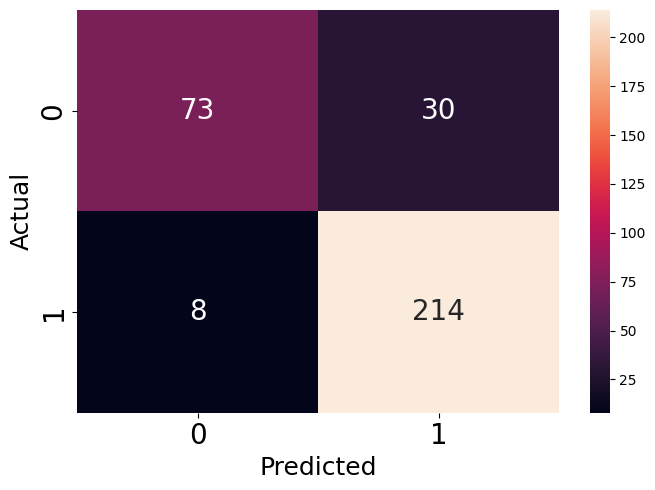

In [ ]:
conf_matrix = confusion_matrix(is_requirement_true, is_requirement_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', annot_kws={"size": 20})
plt.ylabel('Actual', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.tight_layout()
plt.show()

## **Evalutation of Multi-Label Classification**

Of the requirements, it is of interest to assess how good the model is at assigning the correct categories

In [ ]:
# Considera una predizione corretta solo se tutte le etichette per un dato esempio sono predette correttamente.
# Se anche una sola etichetta è sbagliata, l'intero esempio è considerato una predizione errata
print("Accuracy Score:", metrics.accuracy_score(targets, outputs))

Accuracy Score: 0.6307692307692307


In [ ]:
print(classification_report(targets, outputs, target_names=target_list))

                          precision    recall  f1-score   support

                 compute       0.60      0.86      0.70        50
           data handling       0.64      0.90      0.75        30
                 network       0.63      0.84      0.72        31
   security & compliance       0.79      0.89      0.84        63
 management & monitoring       0.86      0.79      0.82        90
cloud service essentials       0.65      0.87      0.74        52

               micro avg       0.71      0.85      0.77       316
               macro avg       0.70      0.86      0.76       316
            weighted avg       0.73      0.85      0.78       316
             samples avg       0.55      0.59      0.55       316



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Hamming Loss = è la proporzione di etichette che sono state erroneamente predette rispetto al numero totale di etichette, una misura di quanto spesso il modello sbaglia.
hl = hamming_loss(targets, outputs)
print("Hamming Loss:", hl)

# Jaccard Similarity Score = misura la somiglianza tra gli insiemi delle etichette vere e quelle predette, esprimendo quanto bene il modello ha identificato solo le etichette corrette senza includere errori.
jaccard = jaccard_score(targets, outputs, average='macro')
print("Jaccard Similarity Score:", jaccard)

Hamming Loss: 0.08102564102564103
Jaccard Similarity Score: 0.619275600208644


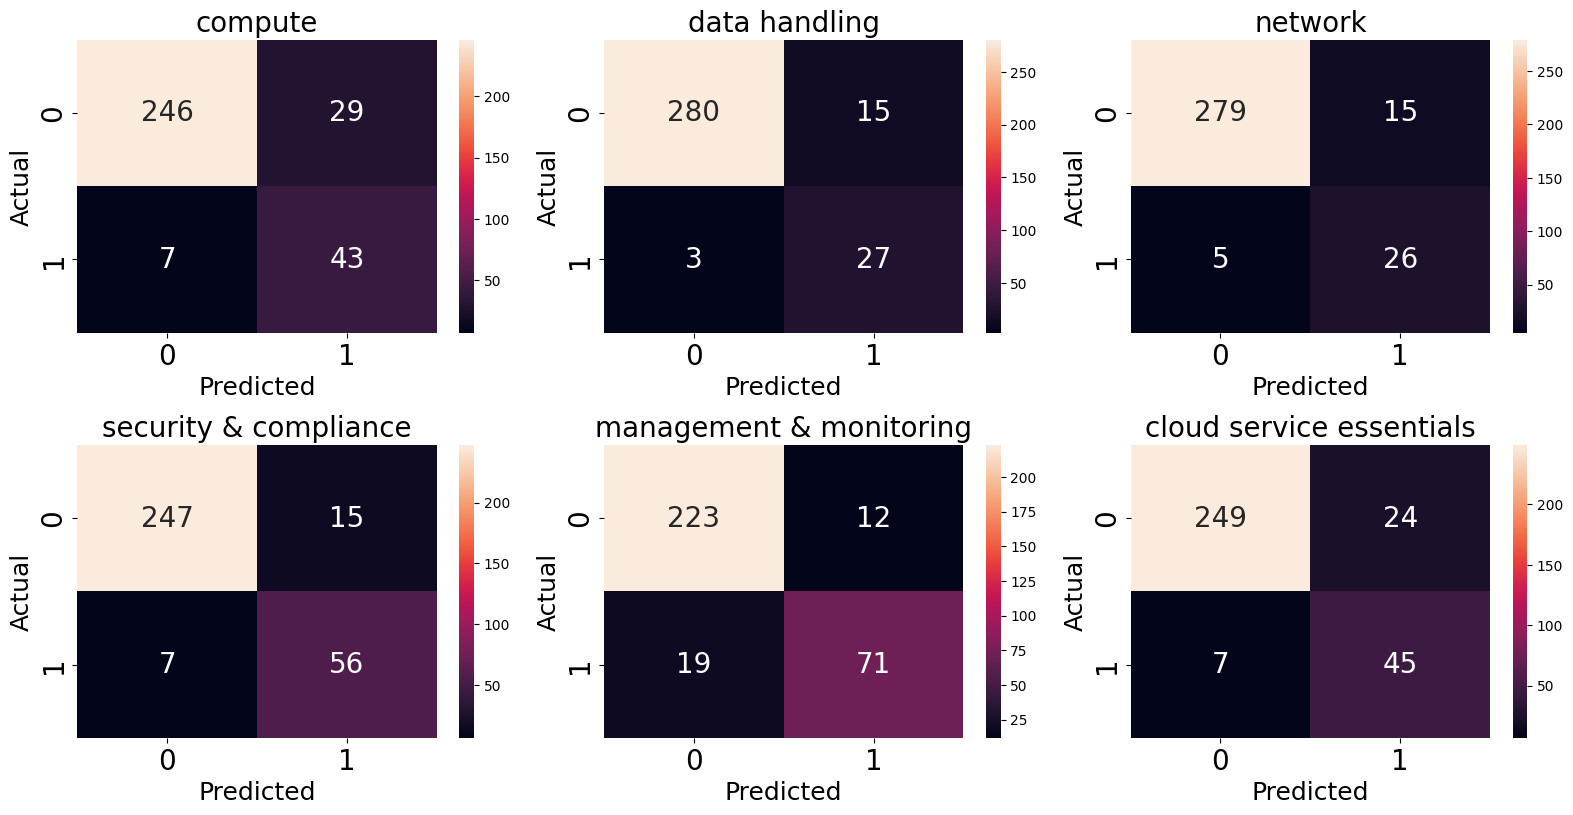

In [ ]:
# Confusion Matrix for each label
plt.figure(figsize=(16, 12))
for i, label in enumerate(target_list):
    cm = confusion_matrix([target[i] for target in targets], [output[i] for output in outputs])
    plt.subplot(3, 3, i+4)  # Adjust the subplot grid as per the number of labels you have
    sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 20})
    plt.title(f"{label}", fontsize=20)
    plt.ylabel('Actual', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()

# [ TN FP
#   FN TP ]
# TN = il modello ha correttamente identificato che "compute" non era presente.
# FP = il modello ha erroneamente identificato "compute" come presente.
# FN = il modello ha mancato di identificare "compute" quando era presente.
# TP = il modello ha correttamente identificato la presenza di "compute".


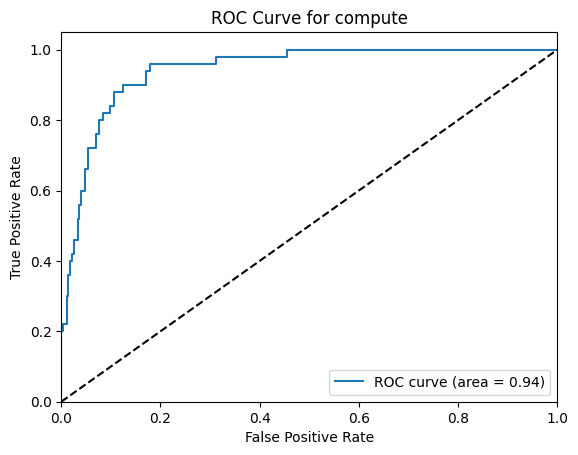

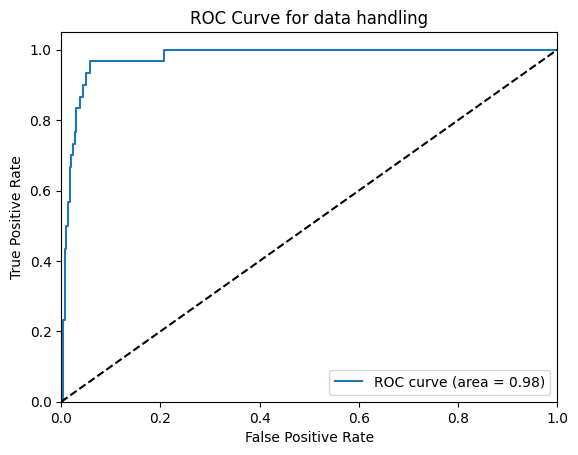

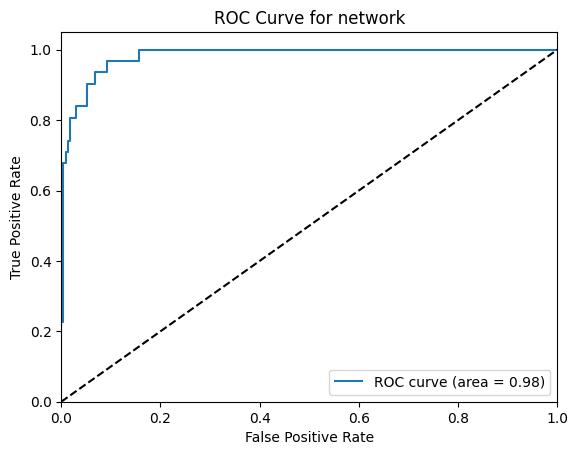

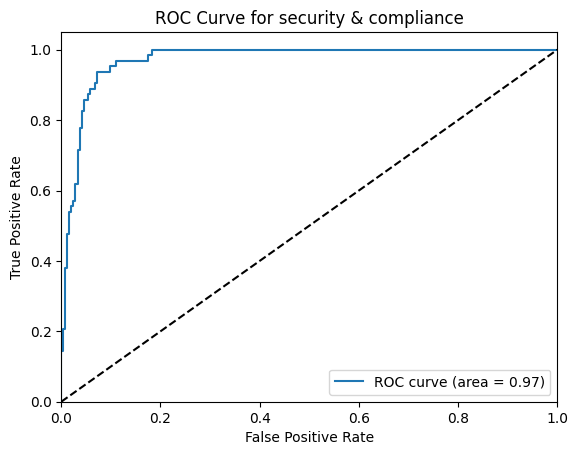

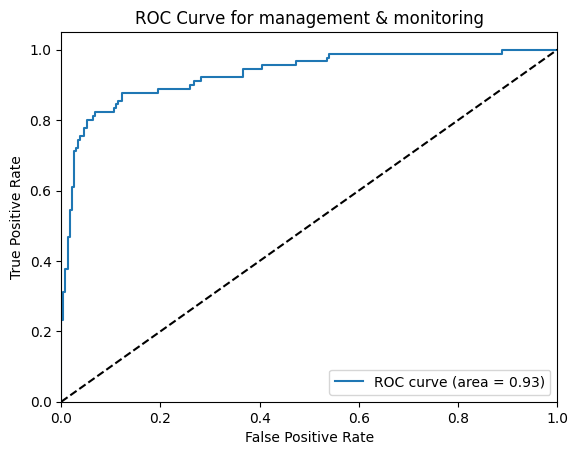

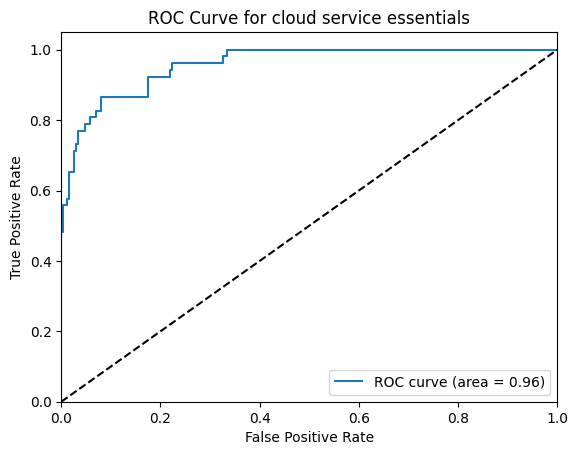

In [ ]:
# Number of classes
n_classes = targets_array.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_array[:, i], probs_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for {}'.format(target_list[i]))
    plt.legend(loc="lower right")
    plt.show()


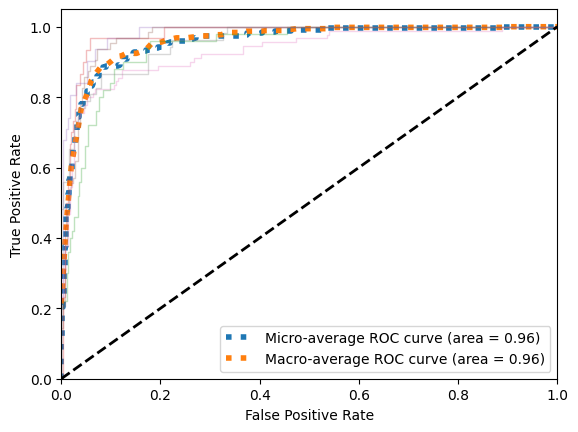

In [ ]:
n_classes = targets_array.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
all_fpr = np.linspace(0, 1, 100)

# Below we merge all the false positive rates and calculate the mean of the true positive rates
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_array[:, i], probs_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally, we divide by the number of classes to get the average
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(targets_array.ravel(), probs_array.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting both macro and micro-averaged ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]), linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=1, alpha=0.3)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Function to calculate per-label accuracies
def label_accuracies(targets_array, outputs_array):
    accuracies = []

    # Calculate accuracy for each label
    for label_idx in range(targets_array.shape[1]):
        label_accuracy = np.mean(targets_array[:, label_idx] == outputs_array[:, label_idx])
        accuracies.append(label_accuracy)

    return accuracies


accuracies_per_label = label_accuracies(targets_array, outputs_array)

# Print the accuracy for each label as a percentage with two decimal places
for idx, acc in enumerate(accuracies_per_label):
    print(f"Accuracy for label {idx}: {acc*100:.2f}%")


Accuracy for label 0: 88.92%
Accuracy for label 1: 94.46%
Accuracy for label 2: 93.85%
Accuracy for label 3: 93.23%
Accuracy for label 4: 90.46%
Accuracy for label 5: 90.46%


# **Testing the model**

In [ ]:
def test_model(sentence: str, model: torch.nn.Module, tokenizer: BertTokenizer, max_len: int, threshold: float, device: torch.device, target_list: list):
    """
    Test the model with an input sentence.

    Args:
        sentence (str): The input sentence to test.
        model (torch.nn.Module): The trained model for prediction.
        tokenizer (BertTokenizer): Tokenizer for encoding the sentence.
        max_len (int): Maximum length for tokenization.
        threshold (float): Threshold for prediction classification.
        device (torch.device): Device to run the model on.
        target_list (list): List of target classes for label interpretation.

    Returns:
        list, list: Predicted labels and raw prediction scores.
    """

    # Tokenize the input sentence
    inputs = tokenizer.encode_plus(
        sentence, None, add_special_tokens=True, max_length=max_len,
        padding='max_length', return_token_type_ids=True, truncation=True,
        return_attention_mask=True, return_tensors='pt'
    )

    ids = inputs['input_ids'].to(device, dtype=torch.long)
    mask = inputs['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = inputs['token_type_ids'].to(device, dtype=torch.long)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        outputs = model(ids, mask, token_type_ids)
        predictions = torch.sigmoid(outputs).cpu().detach().numpy()

    # Interpret the results
    predicted_labels = [target_list[i] for i, value in enumerate(predictions[0]) if value > threshold]

    return predicted_labels, predictions.tolist()

## **Test the model with a single sentence**

In [ ]:
# Testing the model with a sentence
target_list = ['compute', 'data handling', 'network', 'security & compliance', 'management & monitoring', 'cloud service essentials']

def clean_sentence(sentence):
  return sentence


test_sentence = "Solution must provide replication at appropriate level including virtual machine and storage level between primary and DR site"
test_sentence = clean_sentence(test_sentence)

predicted_labels, predictions = test_model(test_sentence, loaded_model, tokenizer, 300, 0.20, device, target_list)

# Map each label with its corresponding probability
label_intensity = { label: round(prob,3) for label, prob in zip(target_list, predictions[0]) }


print("Sentence: ", test_sentence)
print("Predicted Labels and Intensity:", {label: label_intensity[label] for label in predicted_labels} )


Sentence:  Solution must provide replication at appropriate level including virtual machine and storage level between primary and DR site
Predicted Labels and Intensity: {'data handling': 0.77, 'cloud service essentials': 0.725}


# **Generation of CSV of Model Performance on ValidationSet**

In this section of the code, we focus on evaluating the performance of a machine learning model in the context of requirement prediction. The primary objective here is to determine how accurately the model can identify sentences as requirements based on a set of predefined categories. The model predicts a list of categories for each sentence, and if the prediction is not an empty list, the sentence is considered a requirement.

To assess the model's performance, we calculate key metrics such as Precision and Recall. Precision measures the proportion of sentences correctly identified as requirements out of all sentences predicted as requirements, while Recall assesses the proportion of actual requirements that were correctly identified by the model.

We use a confusion matrix approach for this evaluation, where we compute True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) for each sentence in the validation dataset. These values are then used to calculate the overall Precision and Recall of the model.

The process involves iterating over the validation dataset, making predictions using the trained model, and comparing these predictions against the true labels. We then record the results in a DataFrame, which includes the sentence, true labels, predicted labels, and a binary indicator of whether the prediction was correct. Additionally, we create a second DataFrame specifically for the confusion matrix elements (TP, TN, FP, FN) for each sentence.

Finally, the DataFrames are exported to separate sheets in an Excel file for easy analysis and visualization of the model's performance. This step-by-step approach allows us to methodically evaluate the model and gain insights into its strengths and weaknesses in the context of requirement prediction.


In [ ]:
def calculate_confusion_matrix_elements(true_labels, predicted_labels):
    if len(predicted_labels) > 0:  # Il modello prevede che sia un requisito
        if len(true_labels) > 0:  # Ci sono effettivamente etichette vere
            return 1, 0, 0, 0  # TP
        else:
            return 0, 0, 1, 0  # FP
    else:
        if len(true_labels) > 0:  # Modello non prevede requisito, ma è presente
            return 0, 0, 0, 1  # FN
        else:
            return 0, 1, 0, 0  # TN
##################

results = []

for index, row in val_df.iterrows():
    sentence = row['description']

    # Raccogliere le etichette corrette
    true_labels = row['compute':'cloud service essentials'].tolist()
    true_labels = [label for label, binary in zip(target_list, true_labels) if binary == 1]

    predicted_label, probs = test_model(sentence, loaded_model, tokenizer, MAX_LEN, 0.20, device, target_list)

    # Verifica se la previsione è corretta
    is_correct = true_labels == predicted_label

    results.append({
        "sentence": sentence,
        "true label": true_labels,
        "predicted": predicted_label,
        "correctness": is_correct,
        "probabilities": [[round(prob, 3) for prob in sublist] for sublist in probs]
    })

# Creare un DataFrame dai risultati
results_df = pd.DataFrame(results)

# Esportare in un file Excel
results_df.to_excel("./results_validation.xlsx", index=False)

# Genera il secondo DataFrame per TP, TN, FP, FN
confusion_matrix_results = []

for index, row in results_df.iterrows():
    true_label = row['true label']
    predicted_label = row['predicted']
    tp, tn, fp, fn = calculate_confusion_matrix_elements(true_label, predicted_label)

    confusion_matrix_results.append({
        "predicted": 1 if len(predicted_label) > 0 else 0,
        "true label": 1 if len(true_label) > 0 else 0,
        "text": row['sentence'],
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

confusion_matrix_df = pd.DataFrame(confusion_matrix_results)

# Usare ExcelWriter per scrivere in diversi fogli di lavoro
with pd.ExcelWriter("./results_validation.xlsx") as writer:
    results_df.to_excel(writer, sheet_name='Results', index=False)
    confusion_matrix_df.to_excel(writer, sheet_name='Confusion Matrix', index=False)

# Calcolare la somma totale di TP, TN, FP, FN
total_tp = confusion_matrix_df['TP'].sum()
total_tn = confusion_matrix_df['TN'].sum()
total_fp = confusion_matrix_df['FP'].sum()
total_fn = confusion_matrix_df['FN'].sum()

# Calcolare precisione e recall
precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

# Stampare precisione e recall
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 0.8770
Recall: 0.9640
